###  Note to Reader
The following document provides our solutions for the given exercise. The code displayed here is derived from Jan Nagler; the modifications were effectuated in order to make the code more readable and understandable.

At various points in our assignment we provide descriptions of certain key concepts pertinent to the task at hand, irrespective of whether said descriptions are a requisite component of the formal assessment.

# Task

Based on the program developed in the lecture, implement a nonlinear Kernel classification based on SVM for polynomial kernels (poly) and for Gaussian Kernels, i.e., radial base functions (rbf). Apply the analysis to a database of your choice, using the python code as  provided (or your own). Choose (and justify in a small text paragraph) two metrics to optimize for, such as accuracy, precision, recall, f1, f0.5, and f2 score, and determine which combo of hyperparameters maximizes each of the two scores you chose. It would be on you if you want to use GridSearch (as used in the provided code), RandomSearch, or other methods such as hyperopt. It is also on you to try other kernels of your choice. A 2-hyperparameter scan is sufficient. Of course, you are free to scan more parameters, if useful and interesting and doable for you. Do not forget to comment your choices and results in short take-home statements.

In [1]:
#### imports
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

The code was altered, in order to create a more easier way to understand what was done. We decided to go for an object oriented program way. This allowed us to create various classes, which have either data or/and behaviour with that data. The classes which need to be created are: `Data`, `Models`, `Scorer` and `Plot`.

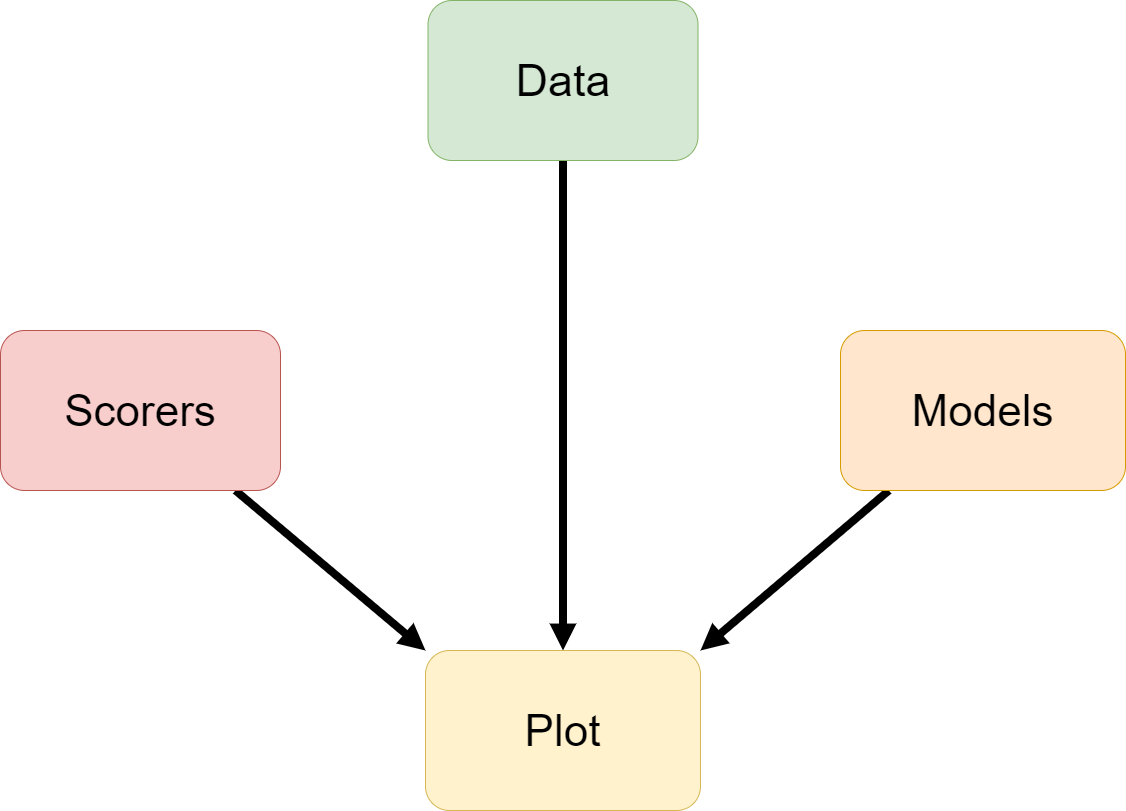

The important note here, is that `Plot` has to inherit attributes from all other three classes. How this is done, and how the classes are constructed is depicted below. This time, the docstrings are directly with the functions.

### Our Dataset
We used data regarding different types of penguins, from which we strove to predict the penguins' sex. 

The data was obtained from the seaborn package.

In [2]:
class Data(object):
    """Class to handle the data"""
    def __init__(self, test_size = 0.2, **kwargs):
        """Instatiates the Data class, using the penguins data from
        seaborn.
        
        Parameters
        ----------
        test_size = float
            Describes the percentage of the test size for the train
            test split        
        """
        data = sns.load_dataset('penguins').dropna().apply(LabelEncoder().fit_transform)
        self.X, self.y = data.iloc[:, :-1], data.iloc[:, -1]
#         self.X, self.y = datasets.load_breast_cancer(return_X_y = True)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size, random_state = 0)
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)
        # The super() method makes sure, that when this class is inherited, to pass on
        # all not needed keyword arguments (kwargs)
        super().__init__(**kwargs)

        
class Models(object):
    """Class which creates the different models"""
    def __init__(self, C=1.0, kernel='poly', gamma='auto', degree = 3, coef0 = 0.0, num_splits = 5, **kwargs):
        """Instantiates the Models class
        
        Parameters
        ----------
        see sklearn SVC and KFold for more information
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.num_splits = num_splits
        self.degree = degree
        self.coef0 = coef0
        super().__init__(**kwargs)
    
    def SVM(self):
        """Instantiates the SVM function
        
        Returns
        -------
        SVC
            The model which can later be used
        """
        try:
            return SVC(C = self.C, kernel = self.kernel, gamma = self.gamma, degree = self.degree, coef0 = self.coef0)
        except ValueError:
            return SVC(C = self.C, kernel = self.kernel, gamma = "auto", degree = self.degree, coef0 = self.coef0)
    
    def KFold(self):
        """Instatiates the KFold
        
        Returns
        -------
        KFold
        """
        return KFold(self.num_splits)
        
        
class Scorer(object):
    """Class to create the scorers on the fly"""
    def __init__(self, beta = 0.2, **kwargs):
        if type(beta) == str:
            self.beta = beta
            self.scorer = beta
        elif type(beta) in [float, int]:
            self.beta = beta
            self.scorer = make_scorer(self.fbeta, greater_is_better = True)
        super().__init__(**kwargs)
        
    def fbeta(self, y_true, y_pred):
        """Instantiates the fbeta scorer, which can be altered with different
        beta values."""
        return fbeta_score(np.array(y_true), np.array(y_pred), beta = self.beta,
                           pos_label = 0 , average = "binary")

    
class FindBestParameters(Data):
    """Class to find the best parameters for our models from Models class"""
    def __init__(self, **kwargs):
        self._gs_result = None
        super().__init__(**kwargs)
    
    def grid_search(self, scoring, param_grid, cv = 5, estimator = SVC(), refit = "f1"):
        if not self._gs_result:
            print("! WARNING: This process takes some time! Please have patience!")
            self._gs_result = GridSearchCV(estimator = estimator, cv = cv, verbose = 1,
                                           scoring = scoring, param_grid = param_grid,
                                           refit = refit)
        
    def return_best_parameters(self):
        self._gs_result.fit(self.X_train, self.y_train)
        parameters = self._gs_result.cv_results_["params"]
        result = {k : [dic[k] for dic in parameters] for k in parameters[0]}
        for i in scoring.keys():
            result['mean_test_' + i] = self._gs_result.cv_results_['mean_test_' + i]
            result['std_test_' + i] = self._gs_result.cv_results_['std_test_' + i]

        self.results = pd.DataFrame(result)
        self.results.loc[self.results.kernel == 'linear', ['degree', 'gamma']] = np.nan
        self.results.loc[self.results.kernel == 'rbf', 'degree'] = np.nan
        self.results.loc[self.results.kernel == 'sigmoid', 'degree'] = np.nan
        self.results.drop_duplicates(inplace = True)
    
    def find_return_best_parameters(self, **kwargs):
        self.grid_search(**kwargs)
        self.return_best_parameters()
        return self.results
        
    
class Plot(Data, Models, Scorer):
    """Class to create plots, which inherits from Data, Models and Scorer"""
    def __init__(self, **kwargs):
        # The next line initializes the inherited classes
        super().__init__(**kwargs)
    
    def create_validation_curve(self, param_name, title, ylim = [0, 1]):
        """Plot the calculated validation_curve"""
        train_scores, valid_scores = validation_curve(self.SVM(), self.X_train, self.y_train, 
                                                      param_name = param_name, param_range = getattr(self, param_name),
                                                      cv=self.KFold(), scoring = self.scorer)
        plt.plot(getattr(self, param_name), train_scores.mean(axis=1), label = 'Training')
        plt.plot(getattr(self, param_name), valid_scores.mean(axis=1), label = 'Test')
        plt.xlabel(param_name)
        plt.ylabel(self.beta)
        plt.ylim(ylim)
        plt.title(title)
        plt.legend()

# Evaluation Metrics
In order to asses the performance of a classifier, it is important to incorporate a numerical evaluation of the algorithm. For this, a variety of performance measures are available. It is essential to make use of an adequate performance measure as their applicability and significance depend on the dataset as well as the specific classification task. In the following, the performance measures *accuracy*, *precision*, *recall*, $f_1$ *score* and $f_\beta$ *score* are explained. The end of this chapter includes our reasoning for the performance measures used during the classification task at hand.

### Accuracy

$$
Accuracy = \frac{True\ Positives + True\ Negatives }{True\ Positives + False\ Positives + True\ Negatives + False\ Negatives}
$$

*Accuracy* measures the performance of a classification model as the number of correct predictions divided by the total number of predictions. Its main advantage is its easy interpretability. Nevertheless, *accuracy* should only be used for balanced datasets. When dealing with imbalanced datasets, i.e. when some classes are much more frequent than others, *accuracy* is not a reliable performance measure. Let's consider a dataset with 99% of the observations belonging to the positive class and the remaining 1% of the observations belonging to the negative class. Implementing a *dumb* classifier, which always predicts *positive*, would yield an *accuracy* of 99% as only the negative observations are wrongly classified. The *accuracy* score may tell us that this is a good model, where indeed its high score is just due to the imbalance in the dataset. As such, other metrics need to be used for the evaluation of the performance of a classification model when faced with an imbalanced dataset.

### Precision

$$
Precision = \frac{True\ Positives}{True\ Positives + False\ Positives}
$$

*Precision* represents the frequency with which predictions are correct. It is also referred to *Positive Predictive Value (PPV)* or *True Positive Accuracy (TPA)*. Precision can be understood as the capability of a classifier not to label negative samples as positive.

### Recall

$$
Recall = \frac{True\ Positives}{True\ Positives + False\ Negatives}
$$

*Recall* represents the frequency with which relevant elements, i.e. true positives, are retrieved by a system. It is also referred to as *True Positive Rate (TPR)* or *Sensitivity*. Recall can be understood as the capability of a classifier to not label positive samples as negative.

### Precision/Recall Trade-off

In an ideal world, precision and recall could always be increased at the same time. Unfortunately, this is not possible. This problem is referred to as the *precision/recall trade-off*. Therefore, it is important to consider what is more important for the classification task at hand.  

In some scenarios, it is reasonable to focus on precision. One example is the classification of movies for children. For a classifier detecting movies that are safe for kids, it is important that the classifier does not label negative samples, i.e. movies for adults, as positive (high precision*). As such, the classifier may also reject adequate movies for kids (low recall), but prevents violent or scary movies being promoted to children.  

In other scenarios, focusing on recall may be more suitable. One example is the application of a classifier used for cancer detection. You may wish to avoid fales negatives, i.e. predictions that someone does not have a cancer while in fact he is suffering from cancer. The objective is to be more confident of predicting benign cancer more precisely.

### $f_1$ Score

$$
f_1 = 2 * \frac{Precision * Recall}{Precision + Recall}
$$

The $f_1$ Score is the harmonic mean of *precision* and *recall*, i.e. it applys equal weight to both.

### $f_\beta$ Score

$$
f_\beta=(1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall} = \frac{1+\beta^2}{\frac{1}{precision}+\frac{\beta^2}{recall}} 
$$

The $f_\beta$ Score allows for variations of the $f_1$ Score. The $\beta$ parameter determines the weight of recall in the combined score. 
- $\beta$ < 1 lends more weight to precision, 
- $\beta$ > 1 favors recall, 
- $\beta$ = 0 consider only precision, 
- $\beta$ = +$\infty$ consider only recall.  

Relevant Information Sources:  
- Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow by Aurelion Geron (2019)
- Juyper Notebook by Jan Nagler: Kernel_v6 (2021)
- Slides Machine Learning 1 by Gregory Wheeler (2021)
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

### Applied Performance Metrics for this Classification Task

For the classification task at hand, we chose *accuracy* and the $f_1$ *score* as performance metrics. The dataset is fairly balanced, which in turn means that *accuracy* is a reliable performance metric. Furthermore, predicting the sex of penguins does not require a special focus on either *precision* or *recall*. The missclassification of a positive example as negative and vice verca is of equal cost. As such, we chose the $f_1$ *score* as it applies equal weight to both *precision* and *recall*.

# Kernel Classification Systems
Kernel classification systems primarily refer to the “kernel trick”, whereby a dataset’s dimensionality is increased in order use a linear classifier for data that would otherwise not be able to be linearly separated. This increase in dimensionality is done without having to calculate the specific location (i.e. coordinates) of each data point in the higher dimensional space. Support Vector Machines (SVMs) are a type of algorithm used during this process. 

Once the data has been transformed into a higher dimension, the optimization objective is to delineate where the hyperplane (i.e. the linear classifier) should be placed to maximize the margin whilst minimizing classification error. In turn, the “margin” refers to the distance between the decision boundary and each support vector, which represent the two instances in each class that are closest to the decision boundary for the adjacent class. 

### Regularization Parameter $C$
The parameter $C$ behaves as a regularization parameter in Support Vector Machines. It is represented by ```C``` in scikit-learns *SVC* with a default value of 0. "The parameter trades off the correct classification of training examples against the maximization of the decision function's margin. For larger values of $C$, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower $C$ will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy." It follows that in the case of overfitting, reducing the $C$ may help improve the performance of the model. When experiencing underfitting, increasing the $C$ may help.

## The Polynomial Kernel
As implied by its name, the polynomial kernel uses a polynomial function to map the original dataset into a higher dimensional space to identify the hyperplane decision boundary between the classes, i.e. create a transformation that makes the problem linearly separable. 

The degree of the polynomial is represented by the hyperparameter ```degree``` in scikit-learn's *SVC*. Its default value is 3. In the case of overfitting, reducing the polynomial degree may help improve the performance of the model. Conversely, in the case of underfitting, increasing the polynomial degree may help.

Furthermore, the parameter $\gamma$ can be tuned for a polynomial kernel. This is not to be confused with the $\gamma$ of the Gaussian Kernel (see further below). Here, $\gamma$ is a prefactor.

As with all kernels presented in this notebook, the regularization parameter *C* can also be tuned to improve the model's performance and reduce over- or underfitting.

### The Polynomial Kernel - Visualization

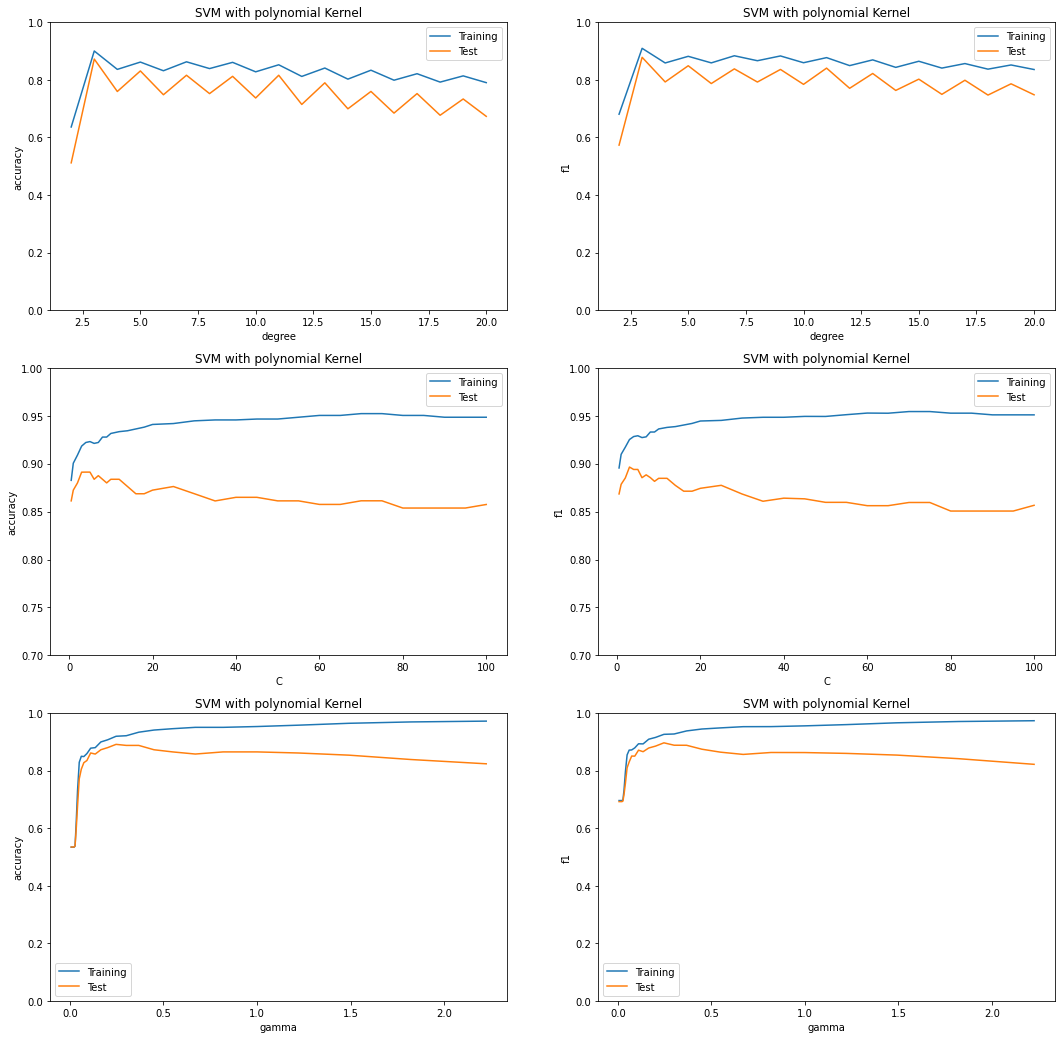

In [3]:
plt_title = "SVM with polynomial Kernel"

plt.figure(figsize = (18, 18))
plt.subplot(3, 2, 1)
Plot(kernel = "poly", degree = np.arange(2, 21, 1), beta = "accuracy").create_validation_curve("degree", plt_title)
plt.subplot(3, 2, 2)
Plot(kernel = "poly", degree = np.arange(2, 21, 1), beta = "f1").create_validation_curve("degree", plt_title)
plt.subplot(3, 2, 3)
Plot(kernel = "poly", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = "accuracy").create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(3, 2, 4)
Plot(kernel = "poly", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = "f1").create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(3, 2, 5)
Plot(kernel = "poly", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = "accuracy").create_validation_curve("gamma", plt_title)
plt.subplot(3, 2, 6)
Plot(kernel = "poly", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = "f1").create_validation_curve("gamma", plt_title)

## The Polynomial Kernel - Analysis
### Impact of the hyperparameter degree

The degree is only applicable for polynomial kernels.  The graphs show that both accuracy and f1 scores decrease as we increase the degree of the polynomial kernel. With degree 3, the model achieves a comparatively better score. A consistent zigzag pattern is observed; with every odd number of degree, the scores tend to increase and then with every even degree they tend to decrease again. Also, as the degree increases, the model begins to overfit the data (this is exhibited by the increasing distance between the accuracy of the training and testing data).

### Impact of the hyperparameter $C$

In a hard margin svm all the sample data points will be outside the margin, meaning that all the points will be correctly classified. However, this may result in a decision boundary with a narrow margin, and this will make the model overfit. 
To overcome this issue a soft margin svm can be helpful. A soft margin means, the svm model allows for some misclassifications, thereby allowing for a greater degree of freedom. The margin will be wider and the model will be more generalizable to new and unseen observations.

In the hinge loss function, the parameter $C$ is called the soft margin parameter. This hyperparameter can also be understood as the regularization parameter. $C$ adds a penalty for each misclassified point. If $C$ is too small, the penalty is small for misclassification and hence a decision boundary with a large margin is chosen. On the other hand, if $C$ is too large the penalty for misclassification is large and hence the model tries to create a decision boundary with a small margin and suffers from overfitting.

A point to keep in mind in this regard is that the penalty is not the same for all misclassified examples; it is directly proportional to the distance to the decision boundary.

The polynomial kernel has shown a similar trend while tuning the hyperparameter $C$ between the range 0.5 and 100, as discussed above. With a very small value of $C$, the model achieves low f1 and accuracy scores. Increasing $C$ slightly causes these scores to increase to their maximum values, after which further increases to $C$ reduce the test accuracy scores as the model overfits.

### Impact of the hyperparameter $\gamma$

While ranging the value of $\gamma$ between 0 and 2.23, the graphs represent that both the accuracy and f1 scores are very low when $\gamma$ is very low. With the increase of $\gamma$ the scores start getting better initially but then the test scores start decreasing and the model overfits.

## Gaussian Kernel (Radial Basis Function) 
$$
exp(-\gamma||x-x'||^2)
$$

The $\textbf{Radial Basis Function (rbf)}$ is used for general purposes, such as when there is no pre-existing understanding/insight into the distribution of the data. The main hyperparameter in the rbf is gamma, which along with $C$ controls over/underfitting by determining the “reach” of each training instance (low gamma means high reach). In effect, this means that with a large gamma the decision boundary will be more dependent on the observations in its immediate vicinity, thereby increasing overfitting on that particular set of training data. $\sigma$ has the same effect as gamma (i.e. it impacts over/underfitting), though an increase to sigma reduces overfitting, whereas as described above an increase to gamma does the opposite (and vice versa - see gamma formula below). 
$$
\gamma = \frac{1}{2\sigma^2}
$$

### Gaussian Kernel (Radial Base Function) - Visualization

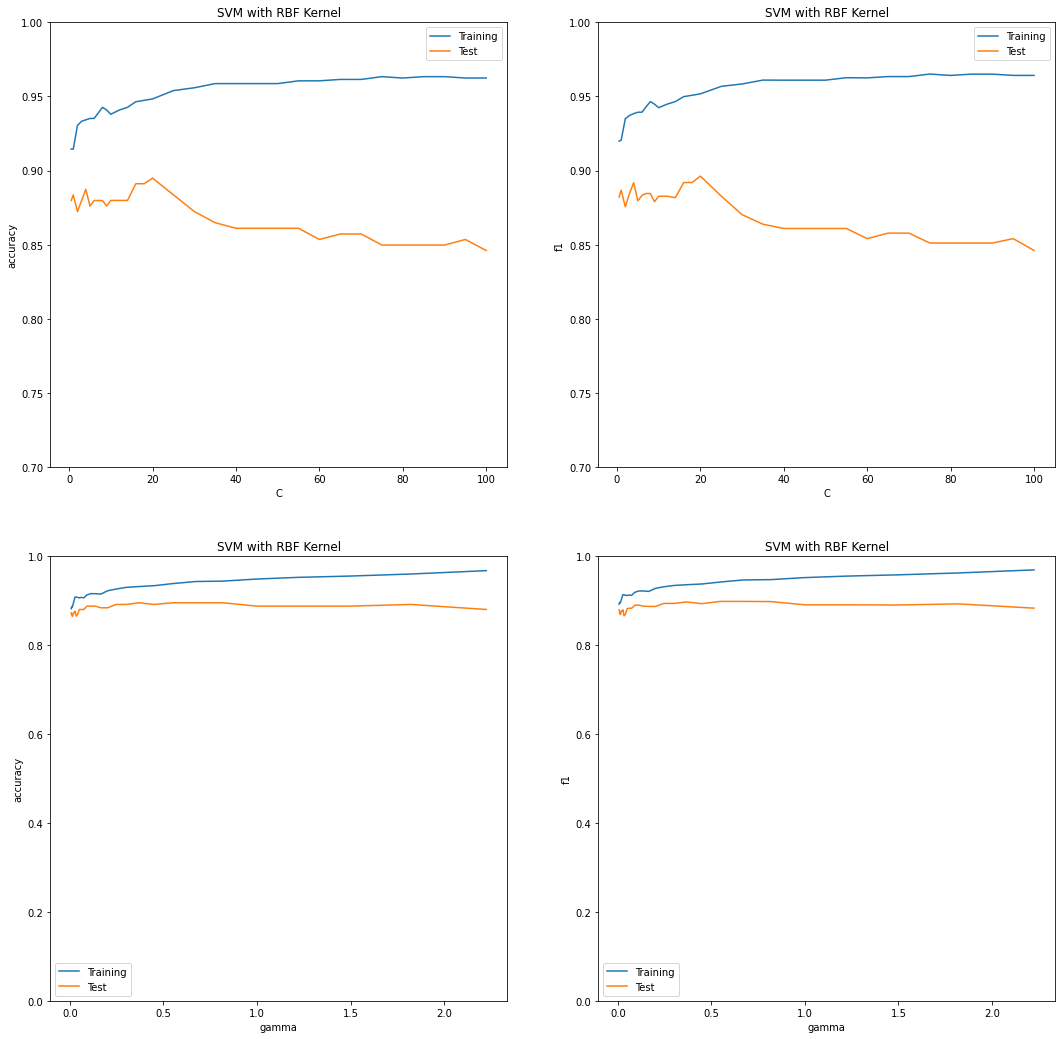

In [4]:
plt_title = "SVM with RBF Kernel"

plt.figure(figsize = (18, 18))
plt.subplot(2, 2, 1)
Plot(kernel = "rbf", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = "accuracy").create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(2, 2, 2)
Plot(kernel = "rbf", C = np.append(np.array([0.5]),
                   np.append(
                       np.append(
                           np.arange(1, 10, 1),  np.arange(10, 20, 2)),
                       np.arange(20, 101, 5))),
     beta = "f1").create_validation_curve("C", plt_title, ylim = [0.7, 1])
plt.subplot(2, 2, 3)
Plot(kernel = "rbf", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = "accuracy").create_validation_curve("gamma", plt_title)
plt.subplot(2, 2, 4)
Plot(kernel = "rbf", gamma = np.exp(np.arange(-5, 1, 0.2)), beta = "f1").create_validation_curve("gamma", plt_title)

## Gaussian Kernels (Radial Basis Function) - Analysis


### Impact of the hyperparameter $C$

The rbf kernel has shown a similar trend while tuning the hyperparameter $C$ between the range 0.5 and 100, as discussed above. With a very small value of $C$, the model achieves low scores for f1 and accuracy. The higher the value of $C$, the higher the training scores but the lower the test scores and the model suffers from an overfitting issue. The best test scores are achieved with a $C$ value around 20.

### Impact of the hyperparameter $\gamma$

The hyperparameter $\gamma$ defines how far the influence of a single training example reaches. If $\gamma$ has a low value, the reach is "far" and if the gamma has a high value the reach is "close". With a high value of $\gamma$ the nearby datapoints will have greater influence and make the decision boundary overfitted, and on the other hand with a low value of $\gamma$ the far points will also contribute and hence the decision boundary will be less complex.

The graphs demonstrate the same concept; with an increasing value of $\gamma$, the model suffers from an overfitting issue.

# Conducting Cross Validation

Cross Validation (CV) is a technique used in machine learning that helps the user determine the optimal hyperparameters for the given model. Two common CV functions used through Python’s scikit-learn library are $\textit{GridSearchCV}$ and $\textit{RandomSearchCV}$. $\textit{GridSearchCV}$ works by looping through the predefined hyperparameters and fits your estimator (model) on your training set, obtaining results for all possible combinations of hyperparameters. While effective, this does impose a substantial computational burden, the scale of which may make $\textit{RandomSearchCV}$ a more appropriate function. Ultimately $\textit{RandomSearchCV}$ works the same as $\textit{GridSearchCV}$, just the number of different hyperparameter combinations it tests is limited by the $\textit{n_iter}$ parameter, so that only a sample of the possible hyperparameter combinations is used during the CV process.

The code that follows determines the optimal hyperparameters given the accuracy metrics we selected (accuracy and the f1 score). It does so through use of the $\textit{GridSearchCV}$ method, as the scale of our dataset is not excessive.

In [5]:
data = FindBestParameters(test_size = 0.2)

In [6]:
param_grid = {'kernel' : ['poly', 'rbf', 'linear', 'sigmoid'],
              'C' : [1, 10, 25, 50, 75, 100],
              'gamma' : [0.01, 0.1, 1],
              'degree' : [2, 3, 4, 5, 7]}              

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : 'recall',
           'f1' : 'f1'}

In [7]:
result = data.find_return_best_parameters(param_grid = param_grid, scoring = scoring)

! WARNING: This process takes some time! Please have patience!
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [8]:
result.sort_values('mean_test_f1', ascending = False)

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
181,50,NaN,0.01,rbf,0.902516,0.040953,0.907527,0.052992,0.916010,0.086050,0.907932,0.043029
301,100,NaN,0.01,rbf,0.902586,0.051361,0.912649,0.054104,0.909113,0.098822,0.906602,0.054522
241,75,NaN,0.01,rbf,0.898812,0.047376,0.906802,0.052886,0.909113,0.098822,0.903432,0.051304
9,1,NaN,1.00,rbf,0.894969,0.053426,0.893814,0.061801,0.915764,0.070971,0.902401,0.050401
65,10,NaN,0.10,rbf,0.891265,0.045652,0.876298,0.039483,0.930296,0.089831,0.899497,0.047322
...,...,...,...,...,...,...,...,...,...,...,...,...
64,10,2.0,0.10,poly,0.609015,0.055180,0.650603,0.075924,0.613300,0.086901,0.625138,0.045902
304,100,2.0,0.10,poly,0.612648,0.054960,0.662202,0.081976,0.591133,0.064450,0.619514,0.045159
8,1,2.0,1.00,poly,0.612648,0.054960,0.662202,0.081976,0.591133,0.064450,0.619514,0.045159
184,50,2.0,0.10,poly,0.608945,0.053034,0.659741,0.081216,0.584236,0.062741,0.614531,0.042303


### Grid Search CV Analysis - f1 Score
The above table shows that the top 5 f1 scores are produced by rbf svm. With a value of 50 for $C$ and a very small value of 0.01 for $\gamma$, the model achieves the best f1 score. Interestingly, one can observe how either the gamma or the $C$ is used for regularization, but not both simultaneously.

Please note, the parameters which are not applicable for a certain svm are displayed as NaN, e.g., degree in rbf svm.

In [9]:
result.sort_values('mean_test_Accuracy', ascending = False)

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
301,100,NaN,0.01,rbf,0.902586,0.051361,0.912649,0.054104,0.909113,0.098822,0.906602,0.054522
181,50,NaN,0.01,rbf,0.902516,0.040953,0.907527,0.052992,0.916010,0.086050,0.907932,0.043029
241,75,NaN,0.01,rbf,0.898812,0.047376,0.906802,0.052886,0.909113,0.098822,0.903432,0.051304
9,1,NaN,1.00,rbf,0.894969,0.053426,0.893814,0.061801,0.915764,0.070971,0.902401,0.050401
302,100,NaN,NaN,linear,0.891335,0.055148,0.904180,0.056696,0.894828,0.097549,0.895750,0.057385
...,...,...,...,...,...,...,...,...,...,...,...,...
240,75,2.0,0.01,poly,0.533823,0.007482,0.533823,0.007482,1.000000,0.000000,0.696037,0.006333
264,75,4.0,0.01,poly,0.533823,0.007482,0.533823,0.007482,1.000000,0.000000,0.696037,0.006333
180,50,2.0,0.01,poly,0.533823,0.007482,0.533823,0.007482,1.000000,0.000000,0.696037,0.006333
300,100,2.0,0.01,poly,0.530049,0.012434,0.532008,0.009444,0.992857,0.014286,0.692766,0.010655


### Grid Search CV Analysis - Accuracy

The above table shows that the top 4 accuracy scores are produced by rbf svm. With a value of 100 or 50 for $C$ and very small value of 0.01 for $\gamma$, the model achieves the best accuracy scores. Once again, one can observe how either the gamma or the $C$ is used for regularization, but not both simultaneously.

After analyzing the CV results it is clear that the rbf svm is performing better for our dataset and hence we will proceed with this model.

In [10]:
# fitting only for best kernel (rbf)
data = FindBestParameters(test_size = 0.2)

In [11]:
param_grid = {'kernel' : ["rbf"],
              'C' : np.append(np.array([0.5]), 
                           np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5))),
              'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/data.X_train.shape[1])}              

scoring = {'Accuracy' : 'accuracy',
           'f1' : 'f1'}

In [12]:
result = data.find_return_best_parameters(param_grid = param_grid, scoring = scoring)

! WARNING: This process takes some time! Please have patience!
Fitting 5 folds for each of 736 candidates, totalling 3680 fits


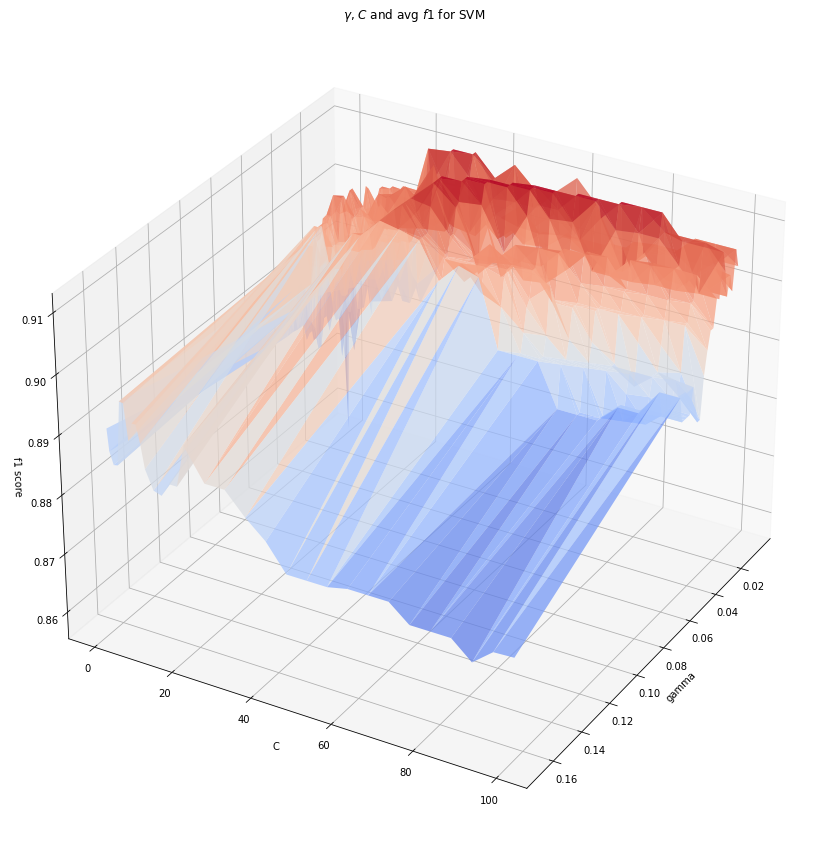

In [13]:
# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result.gamma, result.C, result.mean_test_f1, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f1 score')
ax.view_init(azim=30)    # rotation
plt.title("$\gamma$, $C$ and avg $f1$ for SVM ")
plt.show()

### Surface plot analysis for f1 score in rbf
The above plot shows that a combination of 2 hyperparameters, $C$ in the range of 20-80 and a low $\gamma$ produce the best result. While generally a low gamma may lead to underfitting and a high $C$ may lead to overfitting, this plot shows how the two balance out.

In [14]:
svm_bestf1 = SVC(C = result.sort_values('mean_test_f1', ascending = False).loc[0, 'C'], 
                 gamma = result.sort_values('mean_test_f1', ascending = False).loc[0, 'gamma'],
                 kernel = result.sort_values('mean_test_f1', ascending = False).loc[0, 'kernel'])
svm_bestf1.fit(data.X_train, data.y_train)

y_train_pred = svm_bestf1.predict(data.X_train)
y_test_pred = svm_bestf1.predict(data.X_test)

conf_mat_train = confusion_matrix(data.y_train, y_train_pred)
conf_mat_test = confusion_matrix(data.y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)

Confusion matrix of training sample: 
 [[103  21]
 [ 12 130]]
Confusion matrix of test sample: 
 [[39  2]
 [ 2 24]]


In [15]:
svm_bestacc = SVC(C = result.sort_values('mean_test_Accuracy', ascending = False).loc[0, 'C'], 
                 gamma = result.sort_values('mean_test_Accuracy', ascending = False).loc[0, 'gamma'],
                 kernel = result.sort_values('mean_test_Accuracy', ascending = False).loc[0, 'kernel'])
svm_bestacc.fit(data.X_train, data.y_train)

SVC(C=0.5, gamma=0.008)

## Results

In [16]:
print(f'The mean accuracy of the training data is: {round(svm_bestacc.score(data.X_train,data.y_train),3)*100}%.')

The mean accuracy of the training data is: 87.6%.


In [17]:
print(f'The mean accuracy obtained with the testing data is: {round(svm_bestacc.score(data.X_test,data.y_test),3)*100}%.')

The mean accuracy obtained with the testing data is: 94.0%.
